# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [62]:
# Change here using YOUR first and last names
fn1 = "leo"
ln1 = "treguer"
fn2 = "mehdi"
ln2 = "miah"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_treguer_leo_and_miah_mehdi.ipynb


In [63]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [64]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

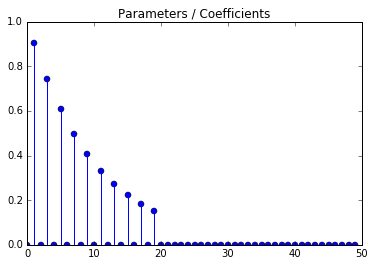

In [65]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [66]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

### Question 1/5 : 
Computing $g(x)$ and $\text{prox}_g(x)$ in both cases

#### Case when g is the Lasso penalization

In [67]:
def lasso(x,s):
    """Value of the Lasso penalization at x"""
    return s*np.linalg.norm(x, ord=1)

def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""  
    return np.sign(x) * np.maximum(np.abs(x) - s*t,0)


#### Case when g is the indicator function

In [68]:
import math

def indicator(x,s):
    """Value of the indicator penalization at x"""
    minimum = np.min(x)
    if minimum < 0:
        res = math.inf
    else:
        res = 0
    return res

def prox_indicator(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""  
    return np.maximum(x, 0)


Plot of the proximal operators


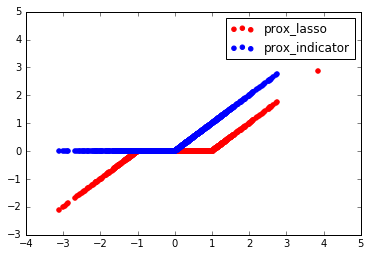

In [69]:
x = randn(1000)

x_barlasso = prox_lasso(x, 0.5, 2)
x_barindic=prox_indicator(x,0.5,2)
plasso=plt.scatter(x = x, y = x_barlasso,color='red',label='prox_lasso')
pindic=plt.scatter(x=x,y=x_barindic,color='blue',label="prox_indicator")

plt.legend(handles=[plasso,pindic])

plt.show()

Influence on coefficients

(-2, 2)

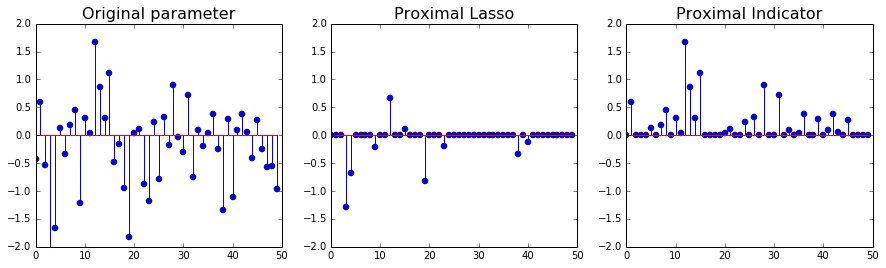

In [70]:
x = randn(50)
l_l1 = 1.
l_l2 = 2

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1,t=1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_indicator(x, s=l_l2,t=1))
plt.title("Proximal Indicator", fontsize=16)
plt.ylim([-2, 2])

### Question 2/5 
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

We consider $F(x)=\frac{1}{2} \|b - Ax\|^2 + g(x)=f(x)+g(x)$

The f function is convex and diffentiable.

The g function is convex in both cases.

### Question 3/5 
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.

In [71]:
def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    #computing all the values of the denominator
    #We compute the denominator outside the for loop for optim
        
    denum_i = [np.dot(A[:,i], A[:,i]) for i in range(n_features)]
        
    for k in range(n_iter + 1):

        #modulo
        i = k % n_features
        
        #We implement the smart residuals update
        r = b - np.dot(A,x)
        ai = A[:,i]
        num = np.dot(ai, r)
        denum = denum_i[i]
        
        #update
        x[i] += prox_g(num/denum, s)   
        
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)])
                 )
    return x, objectives, np.array(errors)

In [72]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 100
s = 1e-1

#Generating A and b
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)

#Test with Indicator function
print("Test with Indicator function")
x_ind, obj_ind,err_ind = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter, x_true=coefs, verbose=True)

#Test with the Lasso function
x_lasso, obj_lasso,err_lasso = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter, x_true=coefs, verbose=True)


Test with Indicator function
Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.13e+03 | 1.09e+00
      10 | 1.11e+03 | 6.73e-01
      20 | 9.62e+02 | 5.96e-01
      30 | 9.61e+02 | 5.96e-01
      40 | 9.55e+02 | 6.00e-01
      50 | 9.53e+02 | 6.01e-01
      60 | 9.53e+02 | 6.01e-01
      70 | 9.53e+02 | 6.01e-01
      80 | 9.53e+02 | 6.01e-01
      90 | 9.53e+02 | 6.01e-01
     100 | 9.53e+02 | 6.01e-01
Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.13e+03 | 1.07e+00
      10 | 9.42e+02 | 6.13e-01
      20 | 7.60e+02 | 5.25e-01
      30 | 7.60e+02 | 5.25e-01
      40 | 7.60e+02 | 5.25e-01
      50 | 5.98e+02 | 3.79e-01
      60 | 5.52e+02 | 3.09e-01
      70 | 5.50e+02 | 3.08e-01
      80 | 5.50e+02 | 3.08e-01
      90 | 5.50e+02 | 3.08e-01
     100 | 5.50e+02 | 3.08e-01


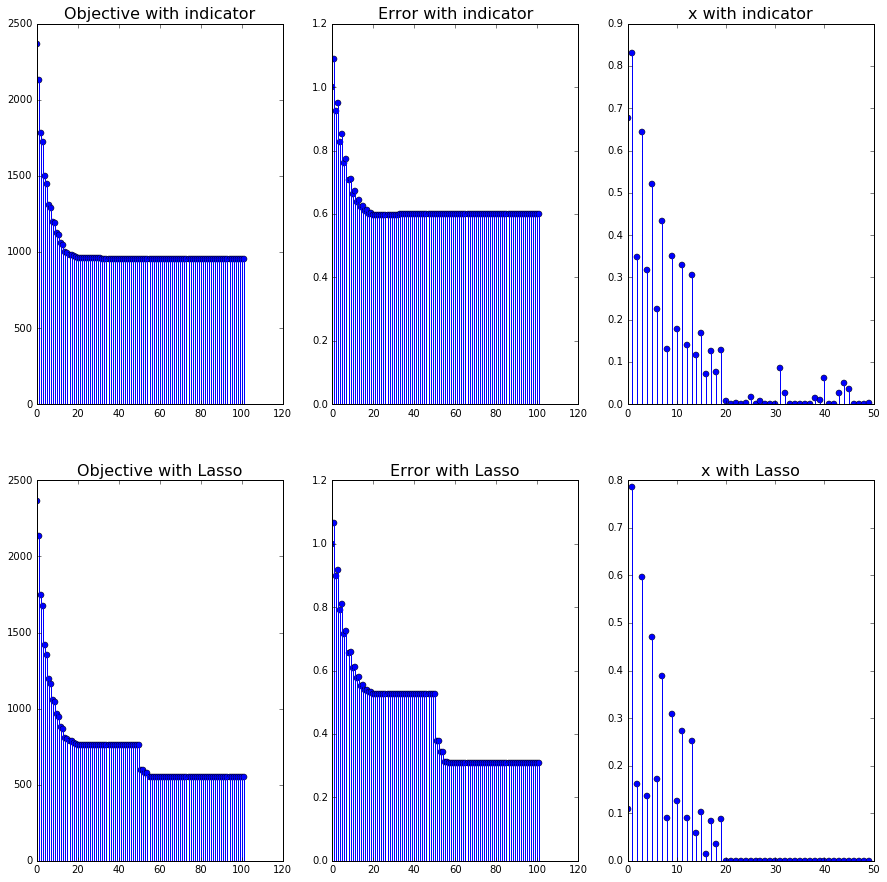

In [73]:
plt.figure(figsize=(15.0, 15.0))

plt.subplot(2, 3, 1)
plt.stem(obj_ind)
plt.title("Objective with indicator", fontsize=16)

plt.subplot(2, 3, 2)
plt.stem(err_ind)
plt.title("Error with indicator", fontsize=16)

plt.subplot(2, 3, 3)
plt.stem(x_ind)
plt.title("x with indicator", fontsize=16)

plt.subplot(2, 3, 4)
plt.stem(obj_lasso)
plt.title("Objective with Lasso", fontsize=16)

plt.subplot(2, 3, 5)
plt.stem(err_lasso)
plt.title("Error with Lasso", fontsize=16)

plt.subplot(2, 3, 6)
plt.stem(x_lasso)
plt.title("x with Lasso", fontsize=16)

Regarding the objective, we notice that the convergence is slightly faster with the indicator function than with the  lasso function since we see a "bump" around the 50th iteration of the algorithm with the lasso function.

We notice the same thing for the error. 

We compare the original parameters with the ones obtained with both the indicator function and the lasso function.

(-0.2, 1)

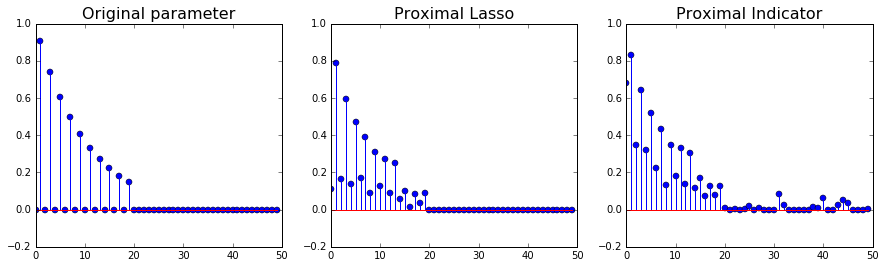

In [74]:
#Comparison of coefficients

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("Original parameter", fontsize=16)
plt.ylim([-0.2, 1])

plt.subplot(1, 3, 2)
plt.stem(x_lasso)
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-0.2, 1])

plt.subplot(1, 3, 3)
plt.stem(x_ind)
plt.title("Proximal Indicator", fontsize=16)
plt.ylim([-0.2, 1])

### Question 4/5
- Evaluate qualitatively the convergence when varying the conditioning of the problem.

We can evaluate the determinant of $A^TA$ as a function of the correlation term in $A$.

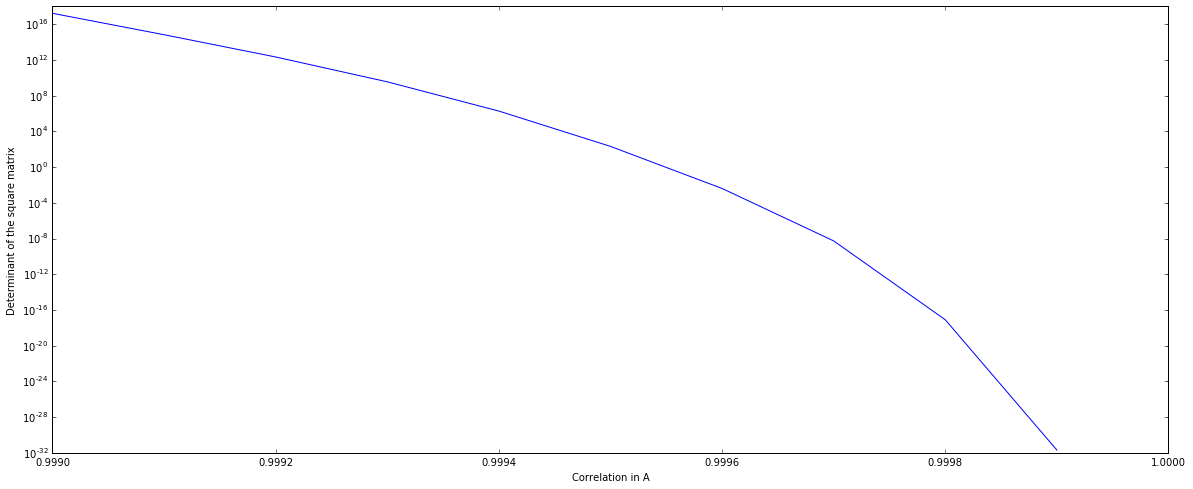

In [75]:
corr_x = 0.999+ np.arange(10)/10000
determinant = list()

for i in range(len(corr_x)):
    A, b = simu_linreg(coefs, n_samples=1000, corr=corr_x[i])
    det = np.linalg.det(np.dot(np.transpose(A), A))
    determinant.append(det)

plt.figure(figsize=(20.0, 8.0))
plt.semilogy(corr_x, determinant)
plt.xlabel('Correlation in A')
plt.ylabel('Determinant of the square matrix')

We observe that the greater the correlation is in A, the lower the determinant of $A^TA$ is. Therefore, this square matrix is no longer invertible.

In [76]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-1

corr_x = 0.9+ np.arange(10)/100
err_corr = []

for i in range(len(corr_x)):

    #Generating A and b
    A, b = simu_linreg(coefs, n_samples=1000, corr=corr_x[i])

    #Test with the Lasso function
    x_lasso, obj_lasso,err_lasso = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter, x_true=coefs, verbose=False)
    
    #Collect error
    err_corr.append(err_lasso)

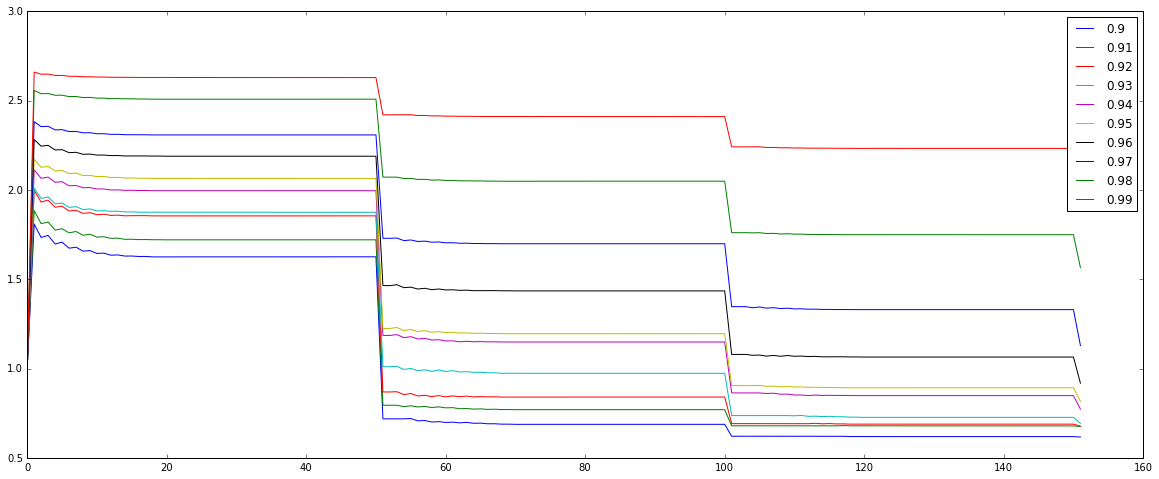

In [77]:
plt.figure(figsize=(20.0, 8.0))

for i in range(len(corr_x)):

    plt.plot(err_corr[i], label = corr_x[i])
    plt.legend()

### Question 5/5 (bonus)

- Bonus: Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

We will reuse the code from the TP1 : 

In [78]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""  
    return np.sign(x) * np.maximum(np.abs(x) - s*t,0)
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s * np.linalg.norm(x, ord=1)

def loss_linreg(x):
    """Least-squares loss"""
    n = len(x)
    res = 1/(2*n) * np.linalg.norm(b-np.dot(A,x), ord=2)**2
    return(res)

def grad_linreg(x):
    """Leas-squares gradient"""
    n = len(x)
    res = 1/n * np.dot(np.transpose(A),np.dot(A,x)-b)
    return(res)

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    res = np.linalg.norm(np.dot(np.transpose(A),A), ord = 2)/len(A[1,])
    return(res)

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true, ord = 2) / np.linalg.norm(x_true, ord = 2)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s, step)

        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true, ord = 2) / np.linalg.norm(x_true, ord = 2)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)])
            )
    return x, objectives, errors

In [79]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 300
s = 1e-2

corr_x = 0.9+ np.arange(1)/10
err_corr_cd = []
err_corr_pdg = []

for i in range(len(corr_x)):

    #Generating A and b
    A, b = simu_linreg(coefs, n_samples=1000, corr=corr_x[i])

    #Test with the Lasso function, descent coordinate
    x_cd, obj_cd,err_cd = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter, x_true=coefs, verbose=False)
    
    #Test with the Lasso function, proximal descent gradient
    step = 1/lip_linreg(A)
    x_pdg, obj_pdg,err_pdg = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, n_iter,x_true=coefs, verbose=False)
    
    #Collect error
    err_corr_cd.append(err_cd)
    err_corr_pdg.append(err_pdg)

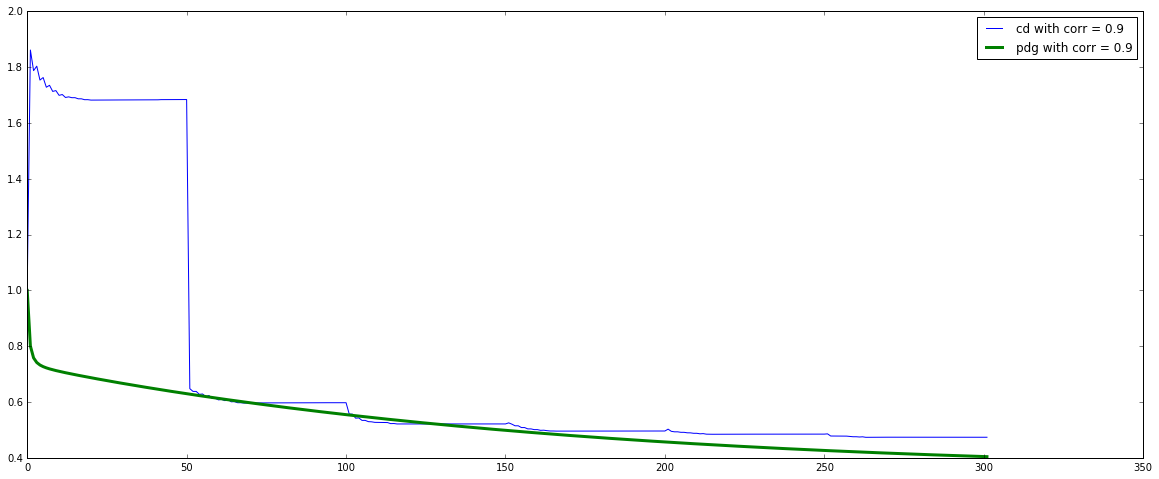

In [80]:
plt.figure(figsize=(20.0, 8.0))

for i in range(len(corr_x)):

    plt.plot(err_corr_cd[i], label = "cd with corr = " + str(corr_x[i]))
    plt.plot(err_corr_pdg[i], label = "pdg with corr = " + str(corr_x[i]), linewidth=3.0)
    plt.legend()